In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import optax

import jax.numpy as jnp
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, AdaptiveFCN
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.analysis import load_model

import fbpinn_wave as fw
from fbpinn_wave import Wave1D
from fbpinn_wave import ExactSine

Código para resolver la ecuación diferencial de onda 1D $u_{xx}-\frac{1}{c^2}u_{tt}=0$ for $x\in[0,L]$ con $u(0,t)=u(L,t)=0$
y $u(x,0)=f(x)$ con $u_t(x,0)=g(x)$ con $0<x<L$.


La solución al problema es:
$$u(x,t)=\frac{F(x-ct)+F(x+ct)}{2}+\frac{1}{2c}\int_{x-ct}^{x+ct}G(s)ds$$
dond|e $F(x)$ es la extensión periódica $2L-$ impar de $f(x)$ y donce $G(x)$ es la extensión periódica $2L-$ impar de $g(x)$

In [2]:
c=3  #Velocidad de la onda en el medio
L=1. #Largo del intervalo espacial donde se desea resolver

x_min = 0
x_max = L
t_min = 0
t_max = 1

La definición de la siguiente clase `Constants()` es lo que armará los distintos hiperparámetros de entrenamiento:

- `subdomain_xs`: Centros de los subdominios rectangulares.
- `domain`: El tipo de dominio junto con las definiciones de sus parámetros de inicialización.
- `problem`: La definición ed la ecuación diferencial a resolver junto con su muestreo y condiciones de contorno.
- `decomposition`: Cómo subdividir los dominios. `subdomain_ws` son los anchos de los dominios. Si bien se pueden escribir manualmente, la función `get_subdomain_ws(subdomain_xs, width)` calcula la mínima distancia entre centros de rectángulos y la escala por `width` para hallar los anchos.
- `network`: Tipo de red neuronal que tendrá cada subdominio.
- `scheduler`: Tipo de planificador. Se usa por si se quiere entrenar las redes en distintos momentos de manera secuencial y no todas de una.

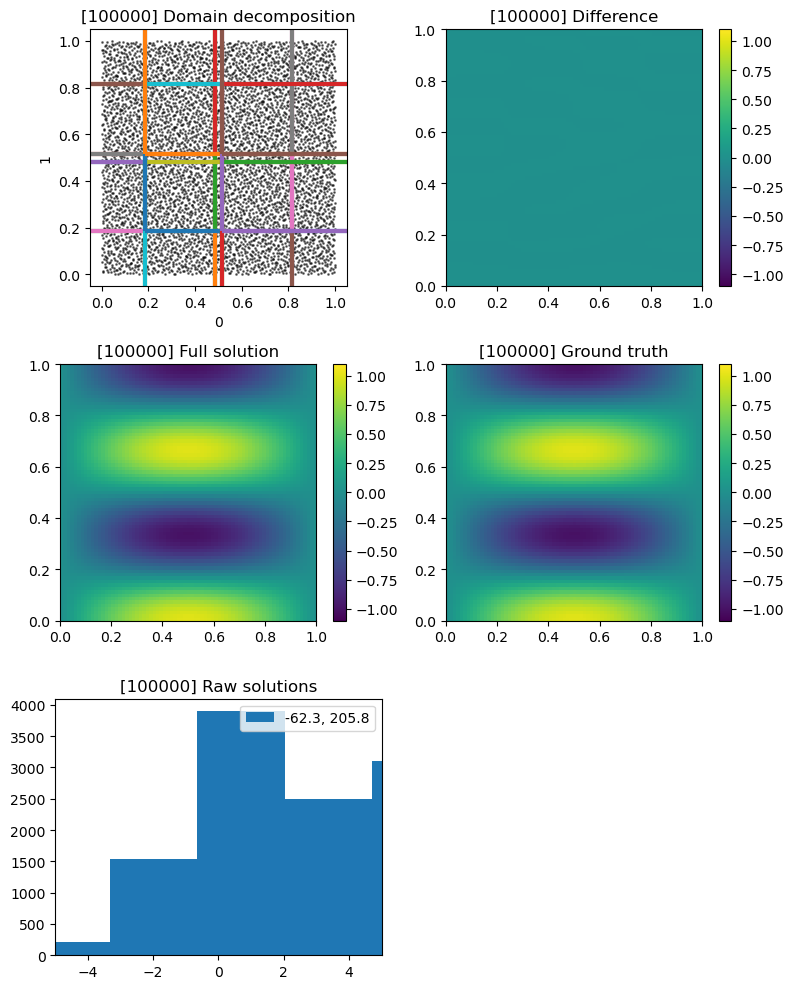

[INFO] 2025-05-05 21:02:35 - [i: 100000/100000] Training complete


In [ ]:
subdomain_xs=[np.linspace(x_min, x_max, 4), np.linspace(t_min, t_max, 4)]
const = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=jnp.array([x_min, t_min]),
        xmax=jnp.array([x_max, t_max]),
    ),
    problem=Wave1D,
    problem_init_kwargs=dict(
        c=c, L=L,
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(-1.,1.),# Desnormalización a utilizar.
    ),
    sampler='halton',# Muestreador de Halton. Se puede usar grilla también.
    seed=0,# Semilla para la inicialización aleatoria de los parámetros.
    optimiser=optax.adam,# Optimizador.
    optimiser_kwargs=dict(
    learning_rate=0.001# Tasa de aprendizaje.
    ),
    network=AdaptiveFCN,# Red fully-connected con activaciones adaptativas (tanh(a*x) con a un parámetro a entrenar).
    network_init_kwargs=dict(
        layer_sizes=(2, 16, 1),# Tamaño de las capas. (2 16 1) significa 2 entradas, una capa de 16 neuronas y una última capa de 1 neurona.
    ),
    #scheduler = LineSchedulerRectangularND,
    #scheduler_kwargs = dict(
        #point=[0.], iaxis=0,# Punto de inicio y eje del planificador.
    #),
    ns=((75, 75),),# Puntos de entrenamiento.
    n_test=(75, 75),# Puntos de testeo.
    n_steps=100000,# Cantidad de épocas.
    clear_output=True,# Si se quiere ir limpiando la información de épocas viejas a medida que pasa el tiempo o no.
)

run = FBPINNTrainer(const)
all_params = run.train()

[INFO] 2025-05-07 17:20:22 - Loading model from:
results/models/test/model_00100000.jax


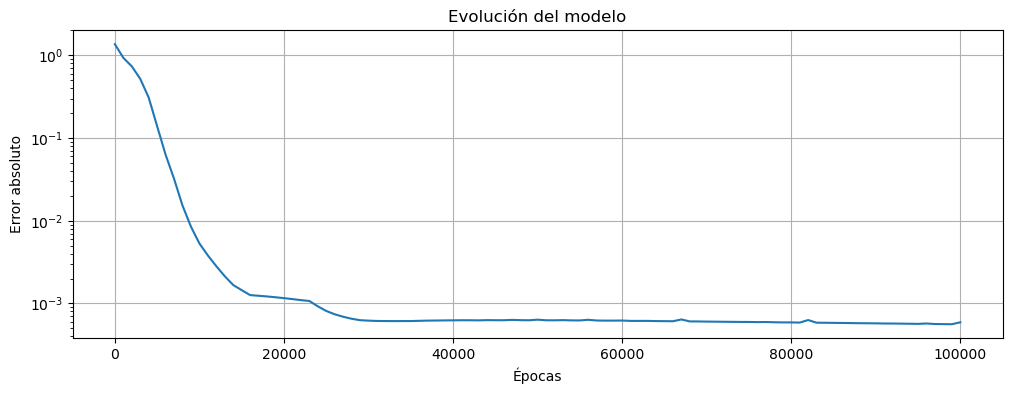

In [ ]:
#Wave1D() #Si no se entrena hay que definir el objeto problema igual
const, model = load_model(run="test", i=100000, rootdir="results/")
i, all_params, all_opt_states, active, u_test_losses = model
fw.plot_model_loss(model, const, axis='Epochs')

[INFO] 2025-05-07 17:20:29 - x_batch
[INFO] 2025-05-07 17:20:29 - (2500, 2), float64, ndarray
[INFO] 2025-05-07 17:20:29 - x_take
[INFO] 2025-05-07 17:20:29 - (16900, 2), float64, ndarray
ECM promedio en todas las soluciones: 1.817e-07


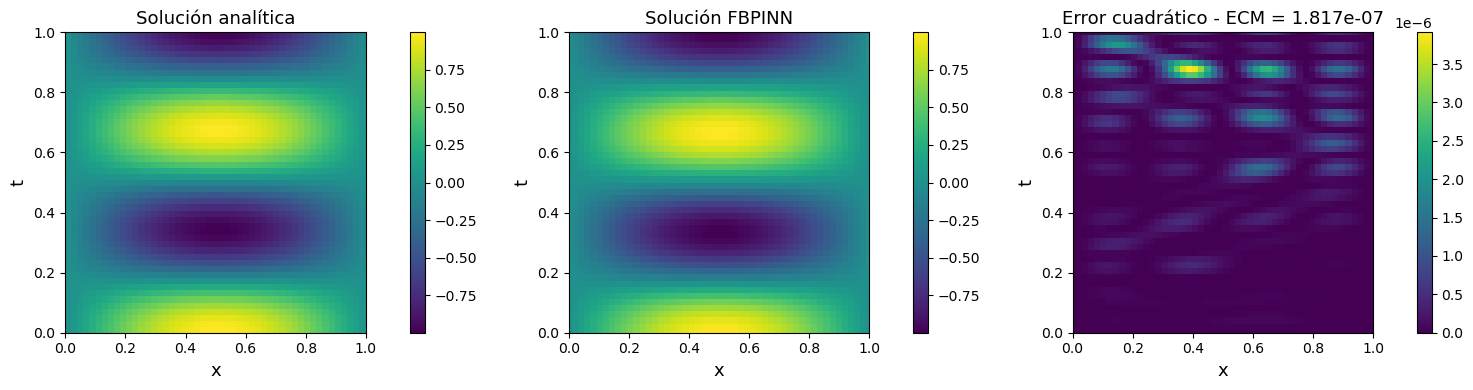

In [4]:
x, t = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, 1, 50), indexing='xy')

analytical_sol = lambda x,t: 0.5*jnp.sin(jnp.pi*(x-c*t))+0.5*jnp.sin(jnp.pi*(x+c*t))
analytical_sol_results=analytical_sol(x,t)

sol = ExactSine(np.linspace(0, L, 50), np.linspace(0, 1, 50), analytical_sol_results.T)

u = fw.compare_solution(model, const, sol)

In [5]:
sol.animation(compare=True, u_compare=u[0].T)

Es interesante notar que el modelo aprende un poco más de los límites de entrenamiento. Extendiendo un 5\% el dominio espacial y un 20\% el temporal se obtiene un buen ECM del orden de $10^{-3}$.

[INFO] 2025-05-07 17:20:55 - x_batch
[INFO] 2025-05-07 17:20:55 - (2500, 2), float64, ndarray
[INFO] 2025-05-07 17:20:55 - x_take
[INFO] 2025-05-07 17:20:55 - (15488, 2), float64, ndarray
ECM promedio en todas las soluciones: 1.857e-03


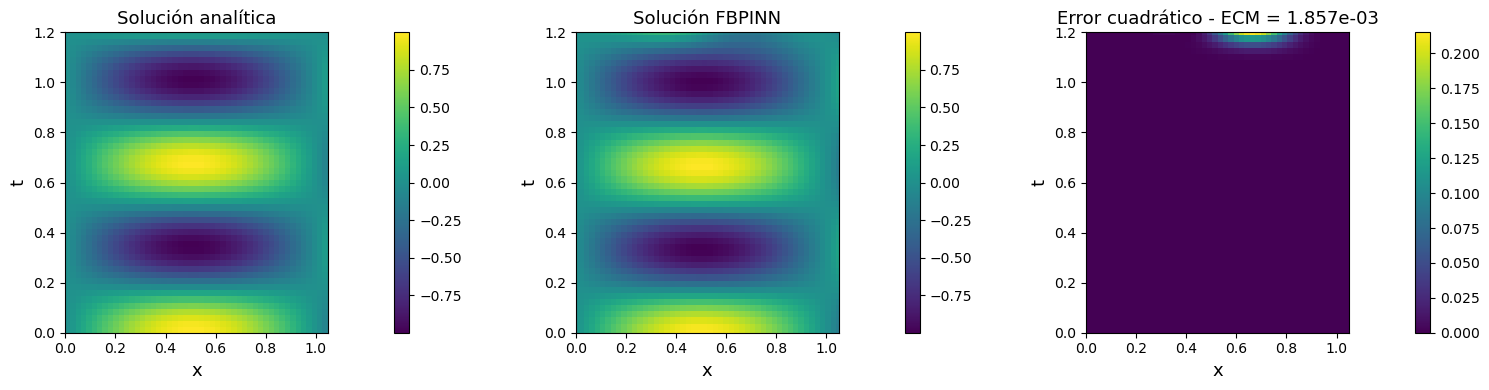

In [6]:
x, t = np.meshgrid(np.linspace(0, L*1.05, 50), np.linspace(0, 1.2, 50), indexing='xy')

analytical_sol = lambda x,t: 0.5*jnp.sin(jnp.pi*(x-c*t))+0.5*jnp.sin(jnp.pi*(x+c*t))
analytical_sol_results=analytical_sol(x,t)

sol = ExactSine(np.linspace(0, L*1.05, 50), np.linspace(0, 1.2, 50), analytical_sol_results.T)

u = fw.compare_solution(model, const, sol)